<a href="https://colab.research.google.com/github/TheBlackRus/liveproject_HumanPoseEstimation/blob/master/liveproject_humanpose_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Human Pose Estimator is now put together!

0. Imports

In [ ]:
import torchvision
import torch
from torch.utils.model_zoo import load_url

%matplotlib inline
#from matplotlib.pyplot import imshow
from matplotlib import image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2

import numpy as np

1. Get the Camera feed!

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  597k  100  597k    0     0   422k      0  0:00:01  0:00:01 --:--:--  421k


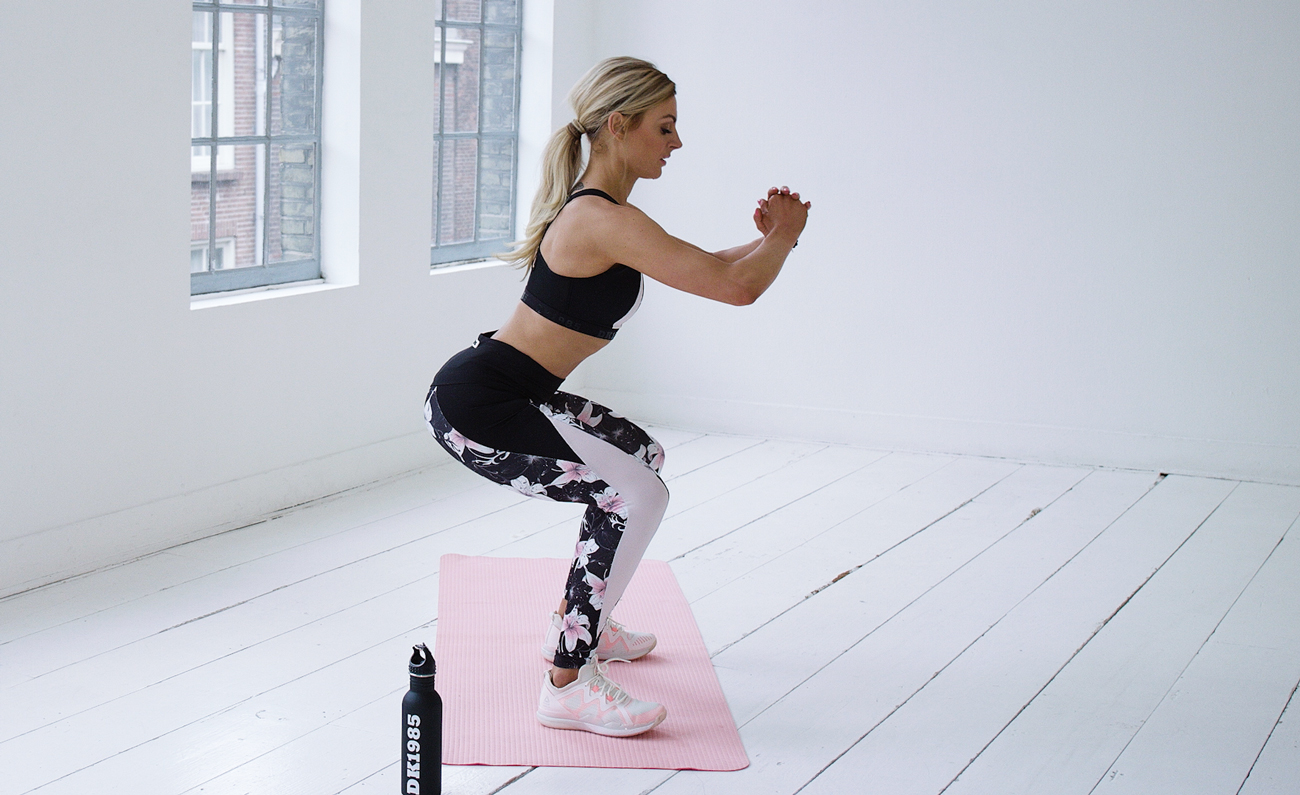

In [ ]:
!curl -o logo.png https://blog.hunkemoller.de/wp-content/uploads/2018/02/Workout_kasiarain_cover.jpg
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('logo.png', cv2.IMREAD_UNCHANGED)

cv2_imshow(img)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_x = img

2. Extract the persons from the image

In [ ]:
class Detector:
  GPU = "cuda"
  CPU = "cpu"
  PERSON_CATEGORY = 1

  def __init__(self,device= GPU):
    self.device = device
    self.model = self.load_model()
    
  def load_model(self):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    #precision = 'fp32'
    #ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision)
    model.eval()
    if self.device == self.GPU:
      model.cuda()
    return model

  def find_person(self,img,preproces=True,
                  category=PERSON_CATEGORY,
                  resize = (192,256),
                  treshold = 0.5,
                  vis=False):
    
    return self.find_object(img,preproces,category,
                            resize=resize,
                            treshold=treshold,
                            vis=vis)

  def find_object(self,img,preproces,category,resize = (192,256),treshold = 0.5, vis=False):
    if preproces:
      img = self.preproces_image(img)

    img_batch = self.single_image_to_batch(img)

    y = self.model(img_batch)

    boxes, scores = self.__get_boxes(y,category,treshold)

    if vis:
      self.vis_boxes(img,boxes)

    res_images = []
    for box in boxes:
      crop_img = self.crop_box(img,box)
      if resize is not None:
        crop_img = self.resize_image(crop_img,resize)
      res_images.append(crop_img)

    return boxes, scores, res_images  

  def vis_boxes(self,img,boxes):
    print("vis",len(boxes))
    fig,ax = plt.subplots(len(boxes)+1,figsize=(20,10))
    if len(boxes):
      ax[0].imshow(img)
      fig.set_dpi(500)
      i= 1
      
      for box in boxes:
        crop_img = self.crop_box(img,box)
        ax[i].imshow(crop_img)
        i +=1
    else:
      ax.imshow(img)
      fig.set_dpi(500)
    plt.show()

  def __get_boxes(self,y,category,treshold):
    if self.device == self.GPU:
      y[0]["labels"] = y[0]["labels"].to("cpu")
      y[0]["scores"] = y[0]["scores"].to("cpu")

    boxes = y[0]["boxes"][np.where(y[0]["labels"]==category)]
    scores = y[0]["scores"][np.where(y[0]["labels"]==category)]
    boxes = boxes[np.where(scores>=treshold)]
    scores = scores[np.where(scores>=treshold)]
    print(boxes, scores)

    return boxes, scores

  def crop_box(self,img,box):
    upper_left_corner = (box[1],box[0])
    size = (box[2]-box[0],box[3]-box[1])

    return self.crop_image(img,upper_left_corner,size)

  def crop_image(self,img, upper_left_corner, size):
    start_x, start_y = upper_left_corner
    w,h = size
    img_cropped = img[int(start_y):(int(start_y+h)),int(start_x):int(start_x+w),:]
    return img_cropped

  def resize_image(self,img, resize =(192,256)):
    target_width, target_height = resize
    img_resized = cv2.resize(img,(target_width,target_height))
    return img_resized

  def preproces_image(self,img):
    img = img / 255.0
    return img

  def single_image_to_batch(self,img):
    img_batch = torch.Tensor([img, img])

    print(img_batch.shape)
    img_batch = img_batch.permute([0,3,2,1])
    print(img_batch.shape)
    if self.device == self.GPU:
      img_batch = img_batch.cuda()
    return img_batch






Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth



torch.Size([2, 795, 1300, 3])
torch.Size([2, 3, 1300, 795])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


tensor([[  58.0257,  421.0484,  632.0544,  818.2531],
        [  53.6279,  373.3011,  723.2944, 1140.3727]], device='cuda:0',
       grad_fn=<IndexBackward>) tensor([0.9631, 0.4264], grad_fn=<IndexBackward>)
vis 2


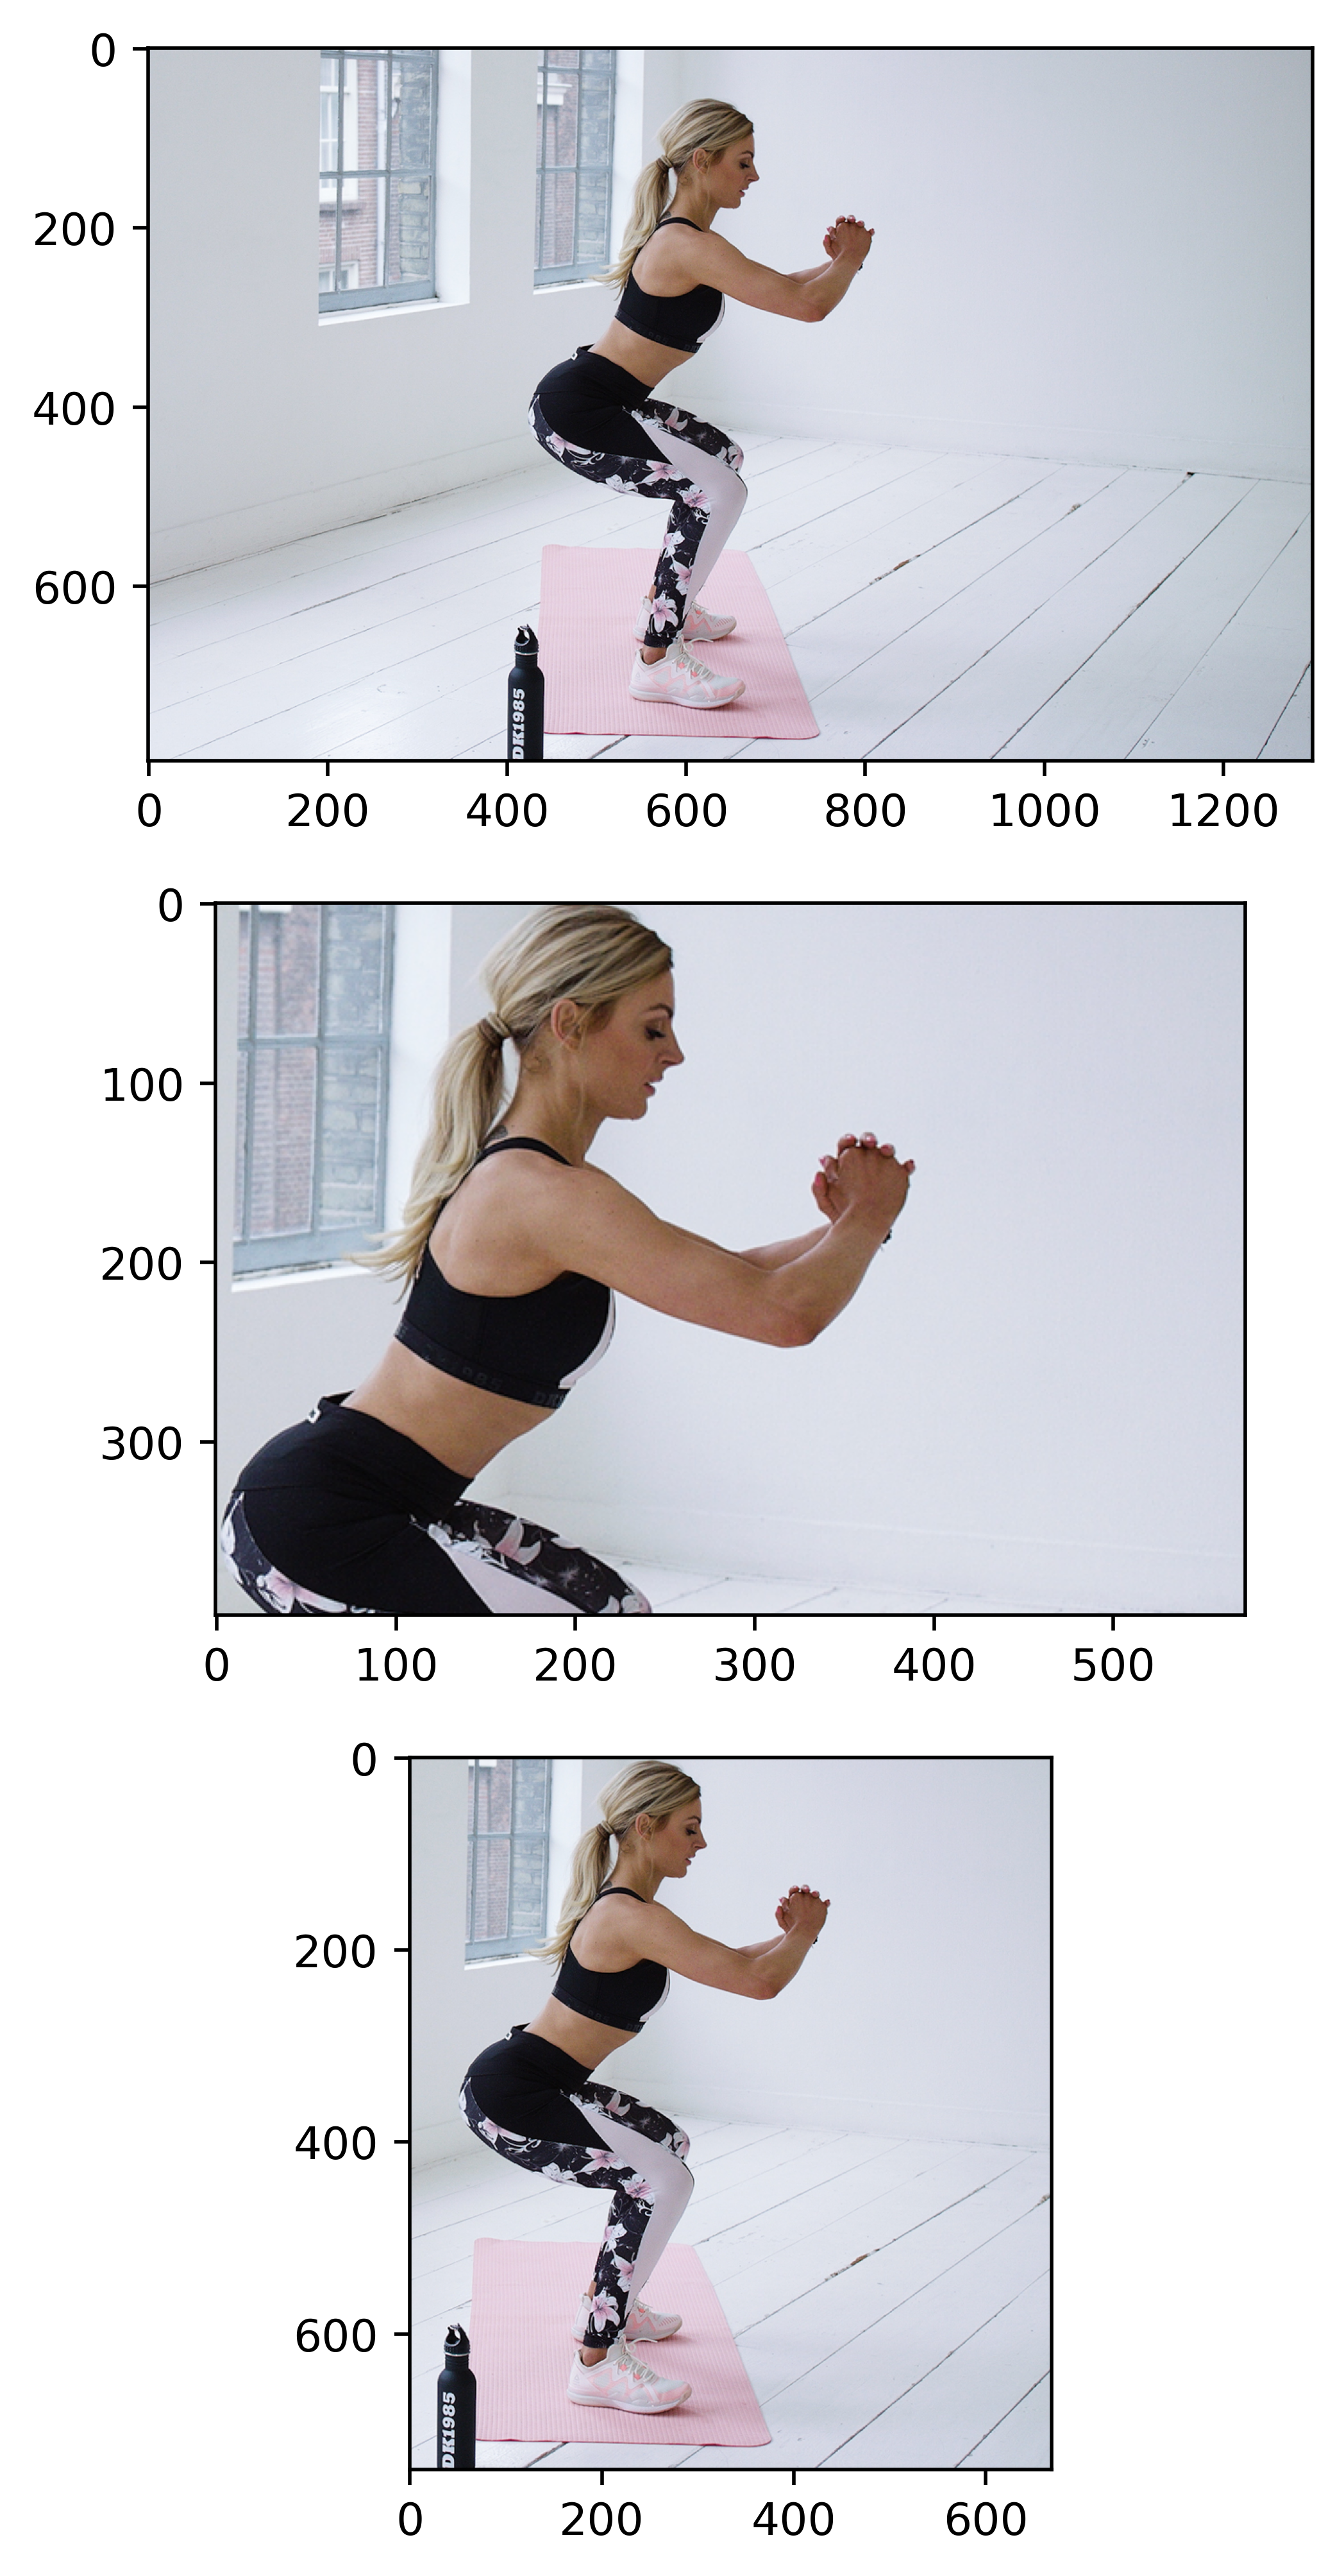

In [ ]:
dec = Detector()
boxes, scores, res_imgs =dec.find_person(img_x,preproces=True,treshold=0.1,vis=True)

Run the Keypoint Estimator!

In [ ]:
import torch.nn as nn
__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        
        #self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        #self.fc = nn.Linear(512 * block.expansion, num_classes)

        self.up1 = nn.ConvTranspose2d(2048, 256, 4, stride=2,padding=1)
        nn.init.normal_(self.up1.weight, std=0.001)
        self.batch_norm_4 = nn.BatchNorm2d(256) # same as out_channels before layer 
        self.relu_4 = nn.ReLU()

        self.up2 = nn.ConvTranspose2d(256, 256, 4, stride=2,padding=1)
        nn.init.normal_(self.up2.weight, std=0.001)
        self.batch_norm_5 = nn.BatchNorm2d(256) # same as out_channels before layer 
        self.relu_5 = nn.ReLU()

        self.up3 = nn.ConvTranspose2d(256, 256, 4, stride=2,padding=1)
        nn.init.normal_(self.up3.weight, std=0.001)
        self.batch_norm_6 = nn.BatchNorm2d(256) # same as out_channels before layer 
        self.relu_6 = nn.ReLU()

        self.fc1 = nn.Conv2d(in_channels= 256, out_channels=17,kernel_size=1,stride=1,padding=0) #nn.Linear(24 * 4 * 4, 10)# 24 chans x 32//(2*2*2)
        self.sig = nn.Sigmoid()


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.up1(x)
        x = self.batch_norm_4(x)
        x = self.relu_4(x)

        x = self.up2(x)
        x = self.batch_norm_5(x)
        x = self.relu_5(x)

        x = self.up3(x)
        x = self.batch_norm_6(x)
        x = self.relu_6(x)
        
        x = self.fc1(x)#x.view(-1, 24 * 4 * 4)
        x = self.sig(x)
        
        

        return x

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)



def resnet34(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)



def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)



def resnet101(pretrained=False, progress=True, **kwargs):
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)



def resnet152(pretrained=False, progress=True, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)



def resnext50_32x4d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)



def resnext101_32x8d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)



def wide_resnet50_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_

    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)



def wide_resnet101_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_

    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
class PoseEstimator:

  def __init__(self,model=None):
    self.model = model if model else self.load_model("drive/My Drive/Manning/experiments/posenet_"+str(4) + "_" + str(500) + '.pth')
    self.model.eval()

    self.mean = [0.485, 0.456, 0.406]
    self.std = [0.229, 0.224, 0.225]

  def load_model(self,path):
    model = resnet50()

    state_dict = load_url(model_urls['resnet50'],progress=True)
    model.load_state_dict(state_dict,strict=False)
    
    state = torch.load( path)
    model.load_state_dict(state['model'])
    
    model.cuda()
    return model

    
  def preproces_img(self,img_crop):
    img = img_crop / 255.0
    img = (img-self.mean)/self.std
    # imgshape (256, 192, 3)
    print("img",img.shape)
    img = np.transpose(img,[2,0,1]) # channel first
    imgs = np.array([img,img])
    return torch.Tensor(img)

  def predict(self,img):
    
    inputs = self.preproces_img(img)
    #labels = labels.squeeze()
    #inputs = torch.Tensor([inputs,inputs])
    inputs = inputs.cuda()
    outputs = self.model(inputs[None, ...])
    
    o = outputs.cpu().detach().numpy()[:,:,:,:]
    return o
    
    

In [ ]:
p = PoseEstimator()

In [ ]:
r = p.predict(res_imgs[1])

img (256, 192, 3)


In [ ]:
r.shape

(1, 17, 64, 48)

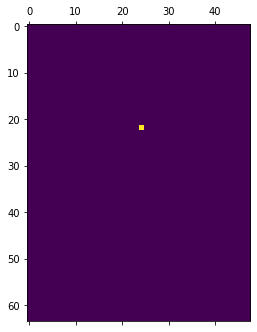

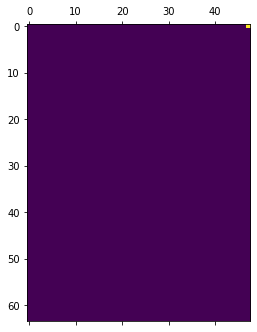

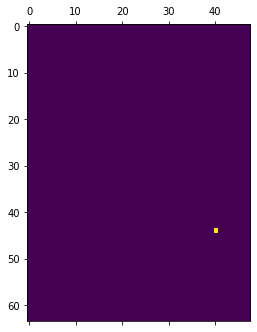

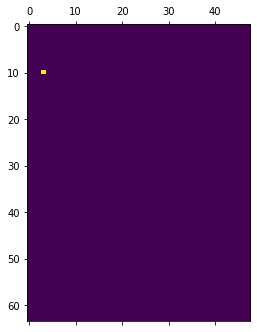

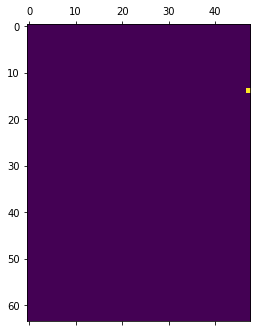

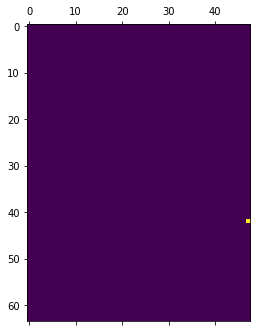

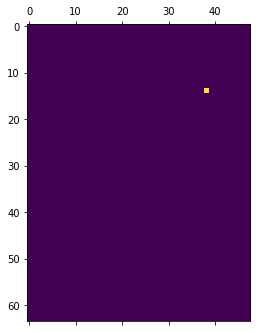

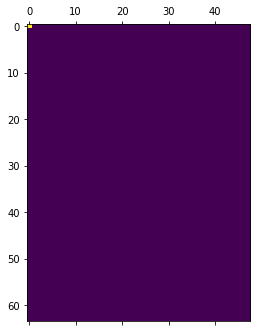

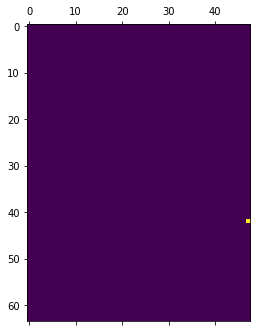

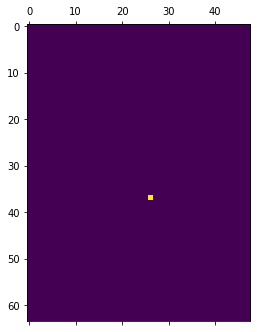

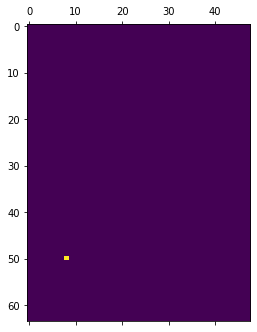

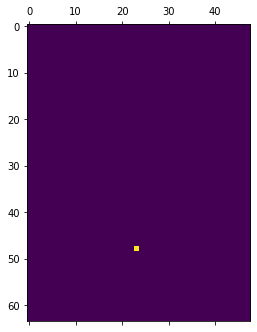

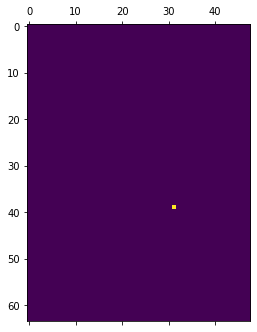

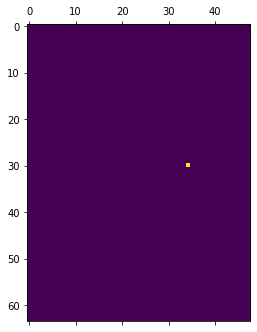

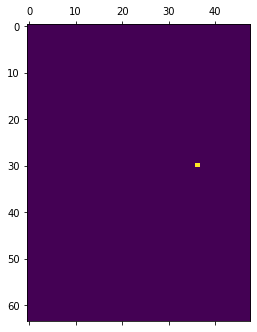

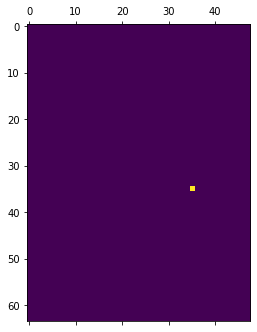

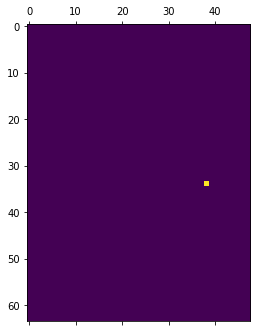

In [ ]:
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
t = res_imgs[1]
for h in range(r[0].shape[0]):
  t+= np.resize(r[0][h],(256,192,3))
  plt.matshow(r[0][h]==r[0][h].max())

In [ ]:
r[0].shape

(17, 64, 48)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


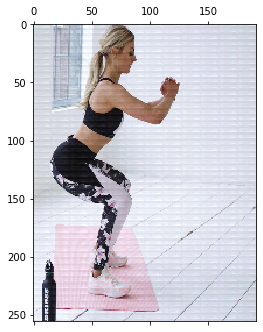

In [ ]:
plt.matshow(t)